# Algortimos genéticos

Optimización de parámetros de Support Vector Machine con Kernel Gaussiano para una tarea de clasificación.

## Procesamiento de texto

In [1]:
import pandas as pd
import numpy as np
import glob
import xml.etree.ElementTree as ET
from gensim.models import Doc2Vec
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import nltk
from sklearn.cross_validation import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier

from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import f1_score as f1
from sklearn import cross_validation

from bitarray import bitarray
import math
import random

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
path_prep_files = 'Training/' # 2-way scientist dataset (trainning)
all_files =  glob.glob(path_prep_files+'*.xml')
print (len(all_files))


135


In [3]:
_fname = "/home/aecarrillor/ASAG/GoogleNews-vectors-negative300.bin"
w2vModel = Doc2Vec.load_word2vec_format(_fname, binary=True)

In [4]:
# crear array con id de pregunta, textos combinados y calificación.

id_question=[]# Identificador de la pregunta (etiqueta de clase).
calif=[]# Marca de criterio.
quest=[]#Pregunta.
ref_answer=[]#Respuesta de referencia.
stud_answ=[]#Respuesta de estudiante.


for doc in all_files:
    tree = ET.parse(doc)
    root = tree.getroot()
    question=root[0].text
    grade_st=[branch.attrib["accuracy"] for branch in root[2]]
    answers_st=[branch.text for branch in root[2]]
    answers_ref=[branch.text for branch in root[1]]# If there are more of 1 reference answer...
    for ith_ans,st_answ in enumerate(answers_st):
        quest.append(question)
        ref_answer.append(answers_ref[0])
        stud_answ.append(st_answ)
        id_question.append(root.attrib["id"])
        st_ans_calif=str(grade_st[ith_ans])
        calif.extend([1 if st_ans_calif=="correct" else 0])

In [5]:
def w2vec_txts(txts):
    return np.array([(sum([w2vModel[word.lower()] for word in nltk.word_tokenize(StAns) if word.lower() in w2vModel ])/
                       len([w2vModel[word.lower()] for word in nltk.word_tokenize(StAns) if word.lower() in w2vModel])) 
                       for StAns in txts])

In [6]:
w2v_questions=w2vec_txts(quest)
w2v_RefAns=w2vec_txts(ref_answer)
w2v_StudAns=w2vec_txts(stud_answ)

In [7]:
Preg_RefAns_StAns=[]
for i in xrange(len(w2v_questions)):
    vec_900=[]
    vec_900.extend(w2v_questions[i])
    vec_900.extend(w2v_RefAns[i])
    vec_900.extend(w2v_StudAns[i])
    Preg_RefAns_StAns.append(vec_900)

(2724, 1)


/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


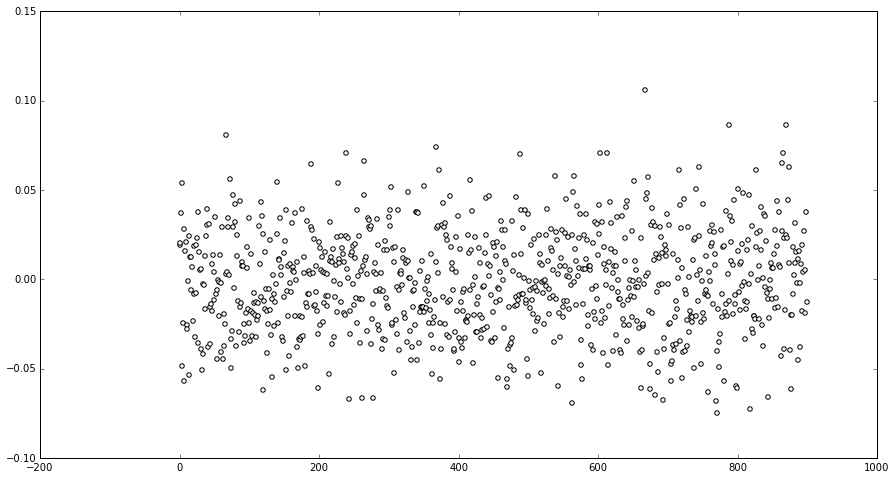

In [8]:
plt.figure(figsize=(15,8))
sample_quest=random.randint(0,len(id_question))
print (sample_quest, calif[sample_quest])
plt.scatter(range(len(Preg_RefAns_StAns[sample_quest])),Preg_RefAns_StAns[sample_quest], c=str(calif[sample_quest]))

In [9]:
# #split data
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v= train_test_split(Preg_RefAns_StAns,calif, test_size=0.25, random_state=42)

In [10]:
# Clasificador lineal optimizado con stochastic gradient descent.
svc = SGDClassifier(loss="hinge", penalty="l2", n_iter=1500)
svc.fit(X_train_w2v, y_train_w2v)
yhat = svc.predict(X_test_w2v)
f1_eval_w2v=f1(y_test_w2v, yhat)
f1_eval_w2v

0.58265895953757219

In [11]:
# Clasificador Kernel Gaussiano.
svr = svm.SVC(kernel='rbf',C=6.8359375,gamma=4.66796875)
svr.fit(X_train_w2v, y_train_w2v)
y_est = svr.predict(X_test_w2v)
f1_svr=f1(y_test_w2v, y_est)
print ("Evoluc:", f1_svr)

('Evoluc:', 0.75301204819277101)


# Evolución de los parámetros

## Funciones de los algoritmos Evolutivos

In [26]:
def pop_indiv(bit_len=22):
    return ''.join([str(random.randint(0,1))for i in range(bit_len)])
    #return ''.join(['1' if bit==True else '0' for bit in bitarray(bit_len)])

def decode_indiv(indiv):
    half=len(indiv)/2
    c_param=    ((int(indiv[:half],2)+1)*20)/float(2**half)
    sigma_param=((int(indiv[half:],2)+1)*20)/float(2**half)
    return [c_param, sigma_param]

def svg_2(indiv):
    #decode_indiv(indiv)
    svr = svm.SVC(kernel='rbf', C=decode_indiv(indiv)[0], gamma=decode_indiv(indiv)[1])
    svr.fit(X_train_w2v, y_train_w2v)
    y_est = svr.predict(X_test_w2v)
    f1_svr=f1(y_test_w2v, y_est, average='weighted')
    return f1_svr


def pop_gener(pop_size, len_ind_bits=22):
    #Generador de poblaciones al azar
    return [pop_indiv(len_ind_bits) for i in xrange(pop_size)]#[bitarray(len_ind_bits) for indiv in xrange(N_pob)]

def fit_vector(population):
    svg_fit=[svg_2(ind) for ind in population]
    return svg_fit#prop_2

def selec_rulet(vec_fitness, n):
    # Devueleve una cantidad n de individuos a partir de la probabilidad proporcional a su fitness (mayor fitness, mayor probabilidad)
    elecs=[]
    probs=[float(p_i)/sum(vec_fitness) for p_i in vec_fitness]
    for i_num in xrange(n):
        r_num=random.random()
        cumsum=[sum(probs[:i+1]) for i in xrange(len(probs))]
        elec=None
        for i_sum in enumerate(cumsum):
            if r_num <= i_sum[1]:
                elec=i_sum[0]# devuleve el índice del seleccionado
                break
        elecs.append(elec)
    return elecs

def mutation(indiv, n_mutations=2):
    code=list(indiv)
    for i in xrange(n_mutations):
        loci=random.randint(0,len(indiv)-1)
        code[loci]=str(abs(int(code[loci])-1))
    return(''.join(code))

def fili(population,fits_popul,n_mutations=4):    
    ith_parents=selec_rulet(fits_popul, 2)
    parents=[population[ith] for ith in ith_parents]
    child_1=parents[0][:int(len(parents[0])*0.25)]+parents[1][int(len(parents[0])*0.25):int(len(parents[0])*0.5)]+parents[0][int(len(parents[0])*0.5):int(len(parents[0])*0.75)]+parents[1][int(len(parents[0])*0.75):]
    child_2=parents[1][:int(len(parents[0])*0.25)]+parents[0][int(len(parents[0])*0.25):int(len(parents[0])*0.5)]+parents[1][int(len(parents[0])*0.5):int(len(parents[0])*0.75)]+parents[0][int(len(parents[0])*0.75):]
    return ([mutation(child_1,n_mutations),mutation(child_2,n_mutations)])

def plot_experim(evolution):
    plt.figure(figsize=(15,8))
    plt.plot(xrange(len(evolution[:,2])),evolution[:,3].astype(float))
    plt.plot(xrange(len(evolution[:,2])),evolution[:,1].astype(float),"g")
    plt.plot(xrange(len(evolution[:,2])),evolution[:,5].astype(float),"r--")
    plt.plot(xrange(len(evolution[:,2])),evolution[:,6].astype(float),"k", alpha=0.4)
    plt.fill_between(xrange(len(evolution[:,3])),evolution[:,6].astype(float)+evolution[:,4].astype(float)*0.5,
                     evolution[:,6].astype(float)-evolution[:,4].astype(float)*0.5,alpha=.3, color="k")
    plt.show()

def experim(iteraciones=200, popul_size=100, bit_len=22, mutaciones=1, ref_rate=100):
    pars_1=pop_gener(popul_size, bit_len)
    evolution=[]
    fitness_population=fit_vector(pars_1)
    evolution=[[len(set(pars_1)),
                max(fitness_population),
                pars_1[fitness_population.index(max(fitness_population))],
                round(np.median(fitness_population),2),
                round(np.std(fitness_population),2),
                round(min(fitness_population),2),
                round(np.mean(fitness_population),2)
               ]]#propiedades de las poblaciones a lo largo de las generaciones

    for i in xrange(iteraciones):
        offsp=[]
        for i in range(popul_size/2):
            offsp.extend(fili(pars_1,fitness_population,mutaciones))
        inds_popul=len(set(offsp))
        fintess_offspring=fit_vector(offsp)
        best_fitness=max(fintess_offspring)
        best_indiv=offsp[fintess_offspring.index(max(fintess_offspring))]
        median_fit=round(np.median(fintess_offspring),2)
        desvest_fit=round(np.std(fintess_offspring),2)
        worst_fitness=round(min(fintess_offspring),2)
        avg_fit=round(np.mean(np.array(fintess_offspring).astype(float)),2)
        evolution.append([inds_popul,best_fitness,best_indiv,median_fit,desvest_fit,worst_fitness,avg_fit])
        # combinar  parents y offsp, y seleccionar.
        generations_AB=pars_1+offsp
        fitness_AB=fit_vector(generations_AB)
        # Selección Ranking
        ranking_df=pd.DataFrame({"indiv":generations_AB,"fit":fitness_AB}).sort_values(by="fit", ascending=False)
        next_gen=[str(bit_sec) for bit_sec in ranking_df["indiv"]]
        #Offspring elegidos
        pars_1=next_gen[:len(pars_1)]
        
        if math.modf(float(i)/ref_rate)[0]==0:
            plot_experim(evolution)
        
    evolution=np.array(evolution)
    evolution[:,3:]=evolution[:,3:].astype(float)
    return evolution



In [28]:
popul_size=20
population_1=[pop_indiv(40) for i in range(popul_size)]
svg_fit=[svg_2(ind) for ind in population_1]
decods=[decode_indiv(ind) for ind in population_1]

[[  4.33206558  11.84900284   0.74505723]
 [ 10.87488174   8.19007874   0.74493927]
 [ 14.74716187   6.40794754   0.74623872]
 [ 17.95938492   9.03057098   0.73780488]
 [ 12.87675858  18.59430313   0.69291339]
 [  9.43332672  19.00527954   0.69152542]
 [ 16.18413925  11.09571457   0.73944387]
 [ 10.05262375  15.09819031   0.72413793]
 [ 18.99227142   5.12020111   0.738     ]
 [  9.46292877   2.83382416   0.73253493]
 [  8.60517502  19.37107086   0.68863636]
 [  2.78623581   3.82497787   0.70612669]
 [  5.53110123   3.36076736   0.7337986 ]
 [  5.05340576   5.82630157   0.75429727]
 [  2.51091003  13.94704819   0.72317597]
 [  2.84345627  11.23916626   0.7348643 ]
 [ 19.44482803  12.3759079    0.7375    ]
 [  9.44036484   2.526474     0.73053892]
 [ 11.22522354  12.87549973   0.73717277]
 [  1.25629425   1.80557251   0.62988506]]


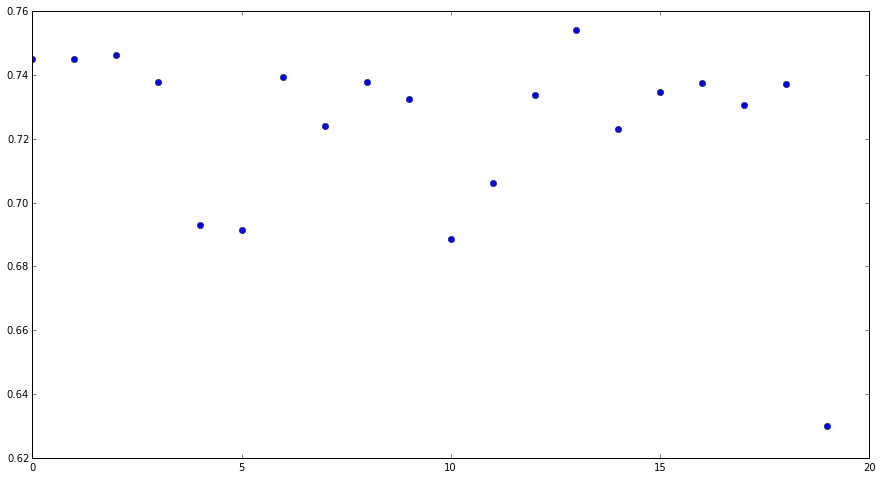

In [29]:
results=(np.array([population_1,np.array(decods)[:,0],np.array(decods)[:,1],svg_fit]).T)
results_float=(np.array([np.array(decods)[:,0],np.array(decods)[:,1],svg_fit]).T)
print(results_float)
plt.figure(figsize=(15,8))
plt.plot(svg_fit, "o")

(array([ 1.,  0.,  0.,  0.,  2.,  1.,  1.,  2.,  9.,  4.]),
 array([ 0.62988506,  0.64232628,  0.6547675 ,  0.66720872,  0.67964994,
         0.69209116,  0.70453238,  0.71697361,  0.72941483,  0.74185605,
         0.75429727]),
 <a list of 10 Patch objects>)

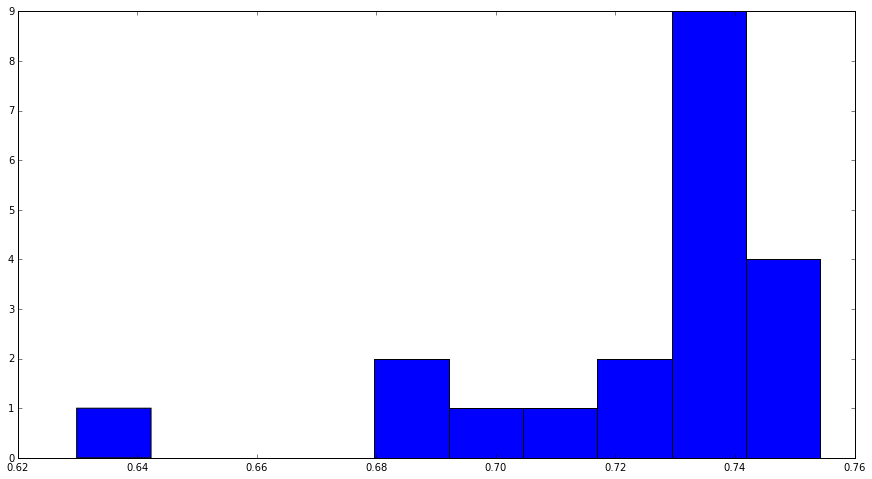

In [30]:
plt.figure(figsize=(15,8))
plt.hist(svg_fit)

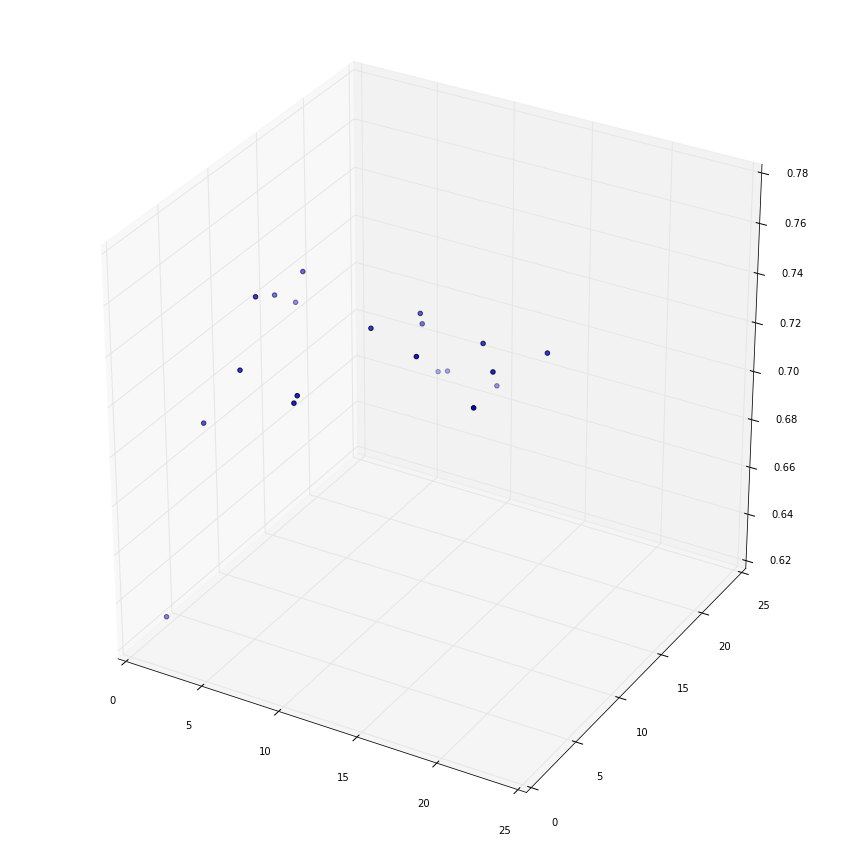

In [31]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(float(results[:,1]),float(results[:,2]),float(results[:,3]))
ax.scatter(np.array(decods)[:,0],np.array(decods)[:,1], svg_fit)
plt.show()


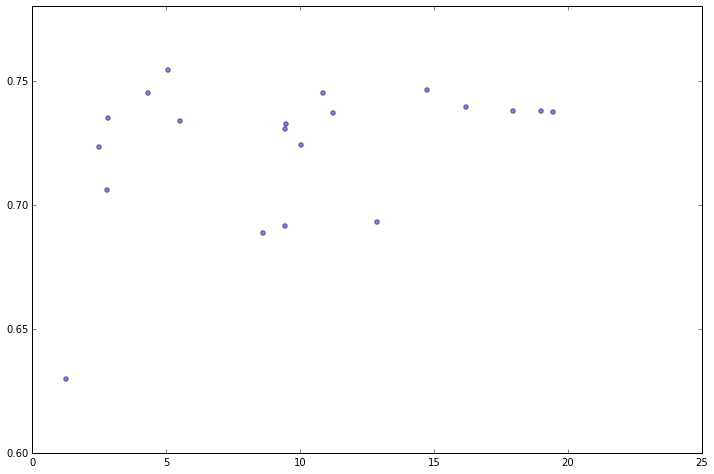

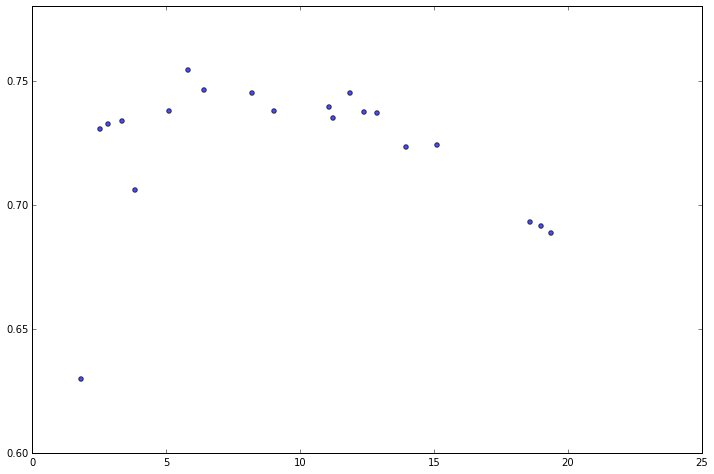

In [34]:
#C param
plt.figure(figsize=(12,8))
plt.scatter(np.array(decods)[:,0],svg_fit, alpha=0.5)
#plt.xlim([3,9])
#plt.ylim([0.65, 0.77])
plt.show()

#Gamma
plt.figure(figsize=(12,8))
plt.scatter(np.array(decods)[:,1],svg_fit, alpha=0.7)
#plt.xlim([3, 9])
#plt.ylim([0.65, 0.77])
plt.show()


In [ ]:
corridas=10
iters=25
tama_pobl=10
mutacs=3
Long_bit=40
experimentos=[]
bst_fit_exps=[]
for i in xrange(corridas):
    corrida=experim(iteraciones=iters, popul_size=tama_pobl, bit_len=Long_bit, mutaciones=mutacs)
    writer = csv.writer(open(''.join(["Results_SVG_10_20/corrida_",str(i),".csv"]), 'w'))
    for iterado in corrida:
        writer.writerow(iterado)
    bst_fit_exps.append(corrida[:,1])
    experimentos.append(corrida)
plt.plot(np.array(bst_fit_exps).T)

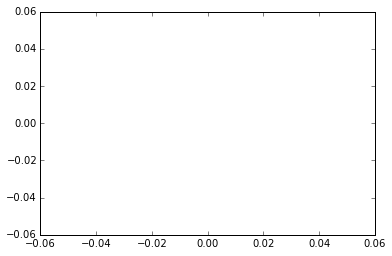

In [40]:
plt.plot(np.array(bst_fit_exps).T)

In [37]:
print(np.array(experimentos))

[[['8' '0.751773049645' '0011111100000111101101000111100100111110' '0.72'
   '0.02' '0.7' '0.72']
  ['8' '0.740365111562' '1101100101100010101101101101011010100100' '0.72'
   '0.03' '0.63' '0.71']
  ['8' '0.747967479675' '0011011100101111100001000111100111101110' '0.74'
   '0.02' '0.69' '0.73']
  ['8' '0.751773049645' '0011111100101011101001000111101101111110' '0.74'
   '0.0' '0.74' '0.74']
  ['8' '0.755825734549' '0011111100101111101001000101100011101110' '0.75'
   '0.01' '0.73' '0.75']
  ['8' '0.751773049645' '0011111100000111101101000111110101111110' '0.75'
   '0.01' '0.72' '0.74']
  ['8' '0.755060728745' '0011111101101101101001000101110011101110' '0.75'
   '0.04' '0.64' '0.74']
  ['8' '0.758341759353' '0011111100000111101101000101000100101010' '0.75'
   '0.01' '0.72' '0.74']
  ['8' '0.755825734549' '0011111100101011111001000101101101001110' '0.75'
   '0.02' '0.69' '0.74']
  ['8' '0.755060728745' '0011101100101101101001001101001011101110' '0.74'
   '0.05' '0.61' '0.72']
  ['8' '0.75

In [ ]:
# import csv
# #print ("decods",np.array(decods))
# writer = csv.writer(open("params.csv", 'w'))
# for i in range(len(svg_fit)):
#     #if counter[row[0]] >= 4:
#     writer.writerow(results[i])


In [33]:
results_best= [
    [6.8359375,4.66796875,0.75301205],
    [5.623413251903491,6.6899022280750415,0.74872838250254325],
    [5.81054688,6.00585938,0.75151515]
    ]

# Test_Code
